<a href="https://colab.research.google.com/github/mrokonuzzaman040/Assignment-4/blob/main/Brain_Tumor_Classification_and_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow opencv-python-headless numpy matplotlib scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Path to the dataset on Google Drive
path_to_training = '/content/drive/My Drive/Dataset/Training'
path_to_testing = '/content/drive/My Drive/Dataset/Testing'

Mounted at /content/drive


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
import cv2

In [4]:
# Image Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create train and test generators
train_generator = train_datagen.flow_from_directory(
    path_to_training,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    path_to_testing,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [5]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,3

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 2148s 23s/step - accuracy: 0.6237 - loss: 1.3266 - val_accuracy: 0.5964 - val_loss: 1.6440
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 2071s 23s/step - accuracy: 0.8428 - loss: 0.4467 - val_accuracy: 0.6269 - val_loss: 1.6562
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 2093s 23s/step - accuracy: 0.8254 - loss: 0.4489 - val_accuracy: 0.6827 - val_loss: 1.3866
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 2096s 23s/step - accuracy: 0.8665 - loss: 0.3499 - val_accuracy: 0.6954 - val_loss: 1.4560
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 2075s 23s/step - accuracy: 0.8834 - loss: 0.3013 - val_accuracy: 0.6726 - val_loss: 1.5838


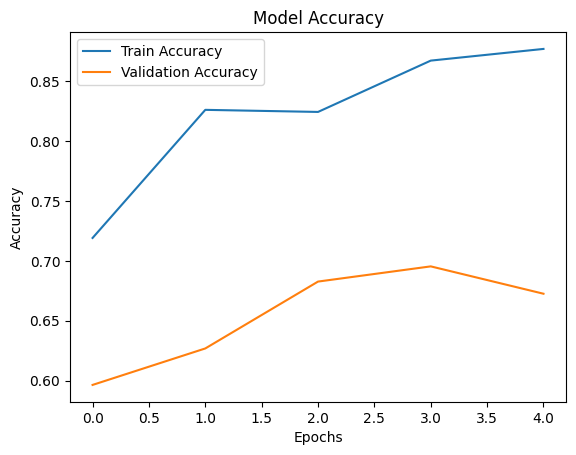

In [6]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=5,
    callbacks=[early_stopping]
)

# Step 6: Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


In [7]:
# Step 7: Save the Trained Model
model.save('/content/drive/My Drive/brain_tumor_model.h5')

print("Model saved successfully!")

Model saved successfully!


In [8]:
# Step 8: Tumor Detection and Region Boundary Visualization
def detect_and_draw_boundary(image_path, model, class_indices):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (224, 224))
    image_array = np.expand_dims(image_resized, axis=0)
    image_preprocessed = preprocess_input(image_array)

    # Predict the tumor type
    prediction = model.predict(image_preprocessed)
    tumor_class = np.argmax(prediction)
    tumor_label = list(class_indices.keys())[tumor_class]

    # Visualize boundaries using Canny edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, threshold1=50, threshold2=150)

    # Overlay edges on the image
    overlay = image.copy()
    overlay[edges != 0] = [0, 255, 0]

    # Display the image
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f'Tumor Class: {tumor_label}')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


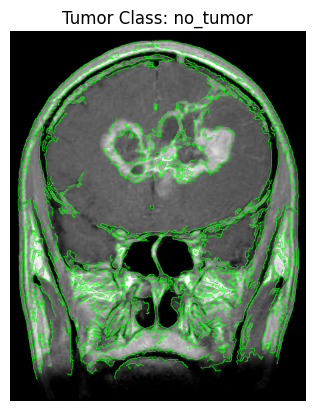

In [ ]:
# Test the function
test_image = '/content/drive/My Drive/Dataset/Testing/glioma_tumor/image-1.jpg'
detect_and_draw_boundary(test_image, model, train_generator.class_indices)

In [ ]:
# Step 9: Evaluate the Model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

 4/13 ━━━━━━━━━━━━━━━━━━━━ 3:03 20s/step - accuracy: 0.7018 - loss: 1.1231